In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import copy
import seaborn as sns
# from sklearn.neighbors import KernelDensity
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
import warnings
%matplotlib inline

In [2]:
PHASE = 'Summer'
# PHASE = 'Winter'

env_varname = 'intqv'

# PF land fraction threshold to separate land vs. ocean MCS
land_frac_thresh = 0.7
ocean_frac_thresh = 0.1

if PHASE == 'Summer':
    track_period = '20160801_20160910'
    block_times = pd.to_datetime(['2016-08-01T00', '2016-08-10T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-15, 30]
if PHASE == 'Winter':
    track_period = '20200120_20200301'
    block_times = pd.to_datetime(['2020-01-20T00', '2020-02-01T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-20, 15]

rootdir = f'/pscratch/sd/f/feng045/DYAMOND/{PHASE}/'

if PHASE == 'Summer':
    name_map = {
        'obs': 'OBS',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'FV3',
        # 'm8': 'ICON',
    }

if PHASE == 'Winter':
    name_map = {
        'obs': 'OBS',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        # 'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'GRIST',
        'm8': 'SCREAM',
        'm9': 'XSHiELD',
        'm10': 'GEOS',
        'm11': 'ICON',
    }

# Environmental files
envfiles_timeseries = {key:f'{rootdir}{value}/envs/{PHASE}_{value}_{env_varname}_timeseries.nc' for key,value in name_map.items()}
rainfiles_timeseries = {key:f'{rootdir}{value}/envs/{PHASE}_{value}_rain_timeseries.nc' for key,value in name_map.items()}
# rainfiles_timeseries = {key:f'{rootdir}{value}/stats/monthly/mcs_rain_timeseries_{track_period}.nc' for key,value in name_map.items()}

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/MCSMIP/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/


## Check if input files exist

In [3]:
for key, value in envfiles_timeseries.items():
    print(f'{value}: {os.path.isfile(value)}')
    
for key, value in rainfiles_timeseries.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/Summer/OBS/envs/Summer_OBS_intqv_timeseries.nc: True
/pscratch/sd/f/feng045/DYAMOND/Summer/ARPEGE/envs/Summer_ARPEGE_intqv_timeseries.nc: True
/pscratch/sd/f/feng045/DYAMOND/Summer/IFS/envs/Summer_IFS_intqv_timeseries.nc: True
/pscratch/sd/f/feng045/DYAMOND/Summer/MPAS/envs/Summer_MPAS_intqv_timeseries.nc: True
/pscratch/sd/f/feng045/DYAMOND/Summer/NICAM/envs/Summer_NICAM_intqv_timeseries.nc: True
/pscratch/sd/f/feng045/DYAMOND/Summer/SAM/envs/Summer_SAM_intqv_timeseries.nc: True
/pscratch/sd/f/feng045/DYAMOND/Summer/UM/envs/Summer_UM_intqv_timeseries.nc: True
/pscratch/sd/f/feng045/DYAMOND/Summer/FV3/envs/Summer_FV3_intqv_timeseries.nc: True
/pscratch/sd/f/feng045/DYAMOND/Summer/OBS/envs/Summer_OBS_rain_timeseries.nc: True
/pscratch/sd/f/feng045/DYAMOND/Summer/ARPEGE/envs/Summer_ARPEGE_rain_timeseries.nc: True
/pscratch/sd/f/feng045/DYAMOND/Summer/IFS/envs/Summer_IFS_rain_timeseries.nc: True
/pscratch/sd/f/feng045/DYAMOND/Summer/MPAS/envs/Summer_MPAS_rai

In [4]:
# Read all data in Xarray Dataset
dse = xr.open_mfdataset(list(envfiles_timeseries.values()), concat_dim='source', combine='nested')
# Assign new coordinate 'source' using names
dse['source'] = list(name_map.keys())
time_env = dse.time
lon_bounds = dse.attrs['lon_bounds']
lat_bounds = dse.attrs['lat_bounds']
dse

<xarray.Dataset>
Dimensions:  (time: 961, source: 8)
Coordinates:
  * time     (time) datetime64[ns] 2016-08-01 2016-08-01T01:00:00 ... 2016-09-10
  * source   (source) <U3 'obs' 'm1' 'm2' 'm3' 'm4' 'm5' 'm6' 'm7'
Data variables:
    intqv    (source, time) float32 dask.array<chunksize=(1, 961), meta=np.ndarray>
Attributes:
    title:       Mean intqv time series
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    lon_bounds:  [-180  180]
    lat_bounds:  [-15  30]
    created_on:  Wed Jan 31 11:12:05 2024

In [5]:
# Read all data in Xarray Dataset
dsr = xr.open_mfdataset(list(rainfiles_timeseries.values()), concat_dim='source', combine='nested')
# Assign new coordinate 'source' using names
dsr['source'] = list(name_map.keys())
time_rain = dsr.time
dsr

<xarray.Dataset>
Dimensions:                 (time: 961, source: 8)
Coordinates:
  * time                    (time) datetime64[ns] 2016-08-01 ... 2016-09-10
  * source                  (source) <U3 'obs' 'm1' 'm2' 'm3' ... 'm5' 'm6' 'm7'
Data variables:
    precipitation           (source, time) float64 dask.array<chunksize=(1, 961), meta=np.ndarray>
    mcs_precipitation       (source, time) float64 dask.array<chunksize=(1, 961), meta=np.ndarray>
    mcs_precipitation_frac  (source, time) float64 dask.array<chunksize=(1, 961), meta=np.ndarray>
    mcs_cloud_frac          (source, time) float64 dask.array<chunksize=(1, 961), meta=np.ndarray>
    ccs_cloud_frac          (source, time) float64 dask.array<chunksize=(1, 961), meta=np.ndarray>
Attributes:
    title:       Mean precipitation time series
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    lon_bounds:  [-180  180]
    lat_bounds:  [-15  30]
    tracker:     PyFLEXTRKR
    created_on:  Wed Jan 31 14:37:46 2024

(0.05, 0.3)

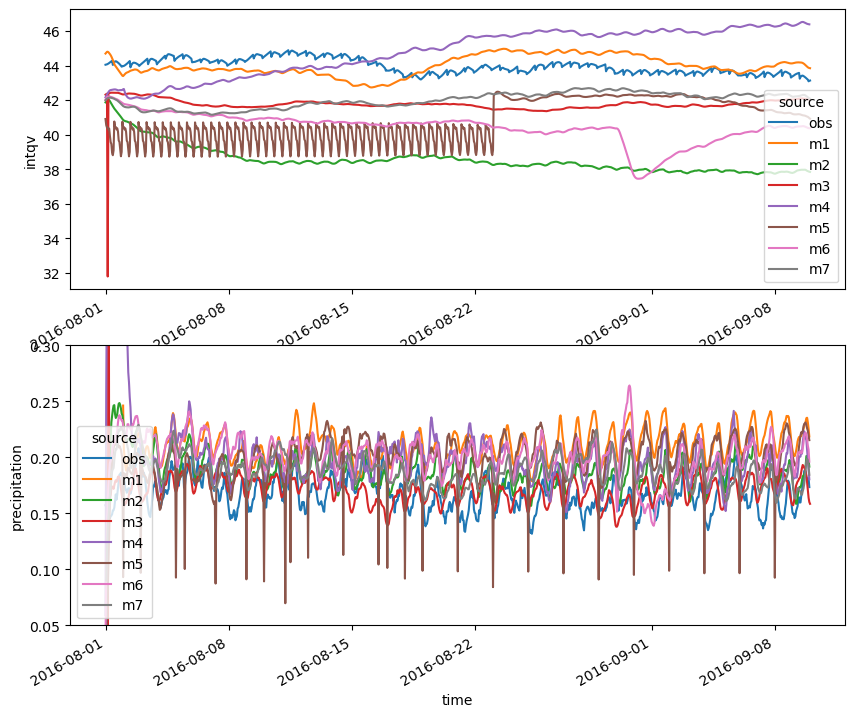

In [6]:
fig, axes = plt.subplots(2, 1, figsize=[10,8], dpi=100)
ax0 = axes[0]
xr.plot.line(dse.intqv, x='time', ax=ax0)
ax1 = axes[1]
xr.plot.line(dsr.precipitation, x='time', ax=ax1)
ax1.set_ylim(0.05, 0.3)

## Do 24-hour running mean to remove the diurnal cycle

In [7]:
window_size = 24  # 24-hour rolling window
dse_s = dse.rolling(time=window_size, min_periods=1, center=True).mean()  # Set center=True for centered rolling mean
dsr_s = dsr.rolling(time=window_size, min_periods=1, center=True).mean()  # Set center=True for centered rolling mean
dse_s

<xarray.Dataset>
Dimensions:  (time: 961, source: 8)
Coordinates:
  * time     (time) datetime64[ns] 2016-08-01 2016-08-01T01:00:00 ... 2016-09-10
  * source   (source) <U3 'obs' 'm1' 'm2' 'm3' 'm4' 'm5' 'm6' 'm7'
Data variables:
    intqv    (source, time) float32 dask.array<chunksize=(1, 960), meta=np.ndarray>
Attributes:
    title:       Mean intqv time series
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    lon_bounds:  [-180  180]
    lat_bounds:  [-15  30]
    created_on:  Wed Jan 31 11:12:05 2024

(0.14, 0.25)

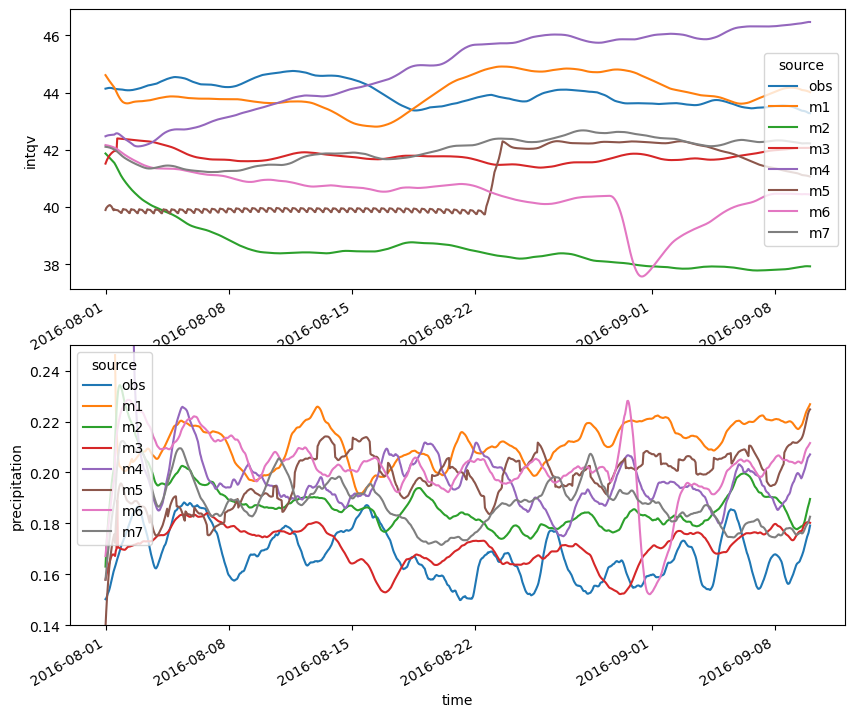

In [8]:
fig, axes = plt.subplots(2, 1, figsize=[10,8], dpi=100)
ax0 = axes[0]
xr.plot.line(dse_s.intqv, x='time', ax=ax0)
ax1 = axes[1]
xr.plot.line(dsr_s.precipitation, x='time', ax=ax1)
ax1.set_ylim(0.14, 0.25)

## Function to plot time series

In [9]:
def plot_time_nrow(nrow, time_data, data_arr, titles, xlabels, ylabels, legends, figname,  
                    map_extent=None, lonbox=None, latbox=None, inset_param=None, map_panel=[0,0],
                    xscale=None, yscale=None, xlims=None, ylims=None, block_times=None,
                    legend_prop=None, fontsize=None, figsize=[10,10]):

    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'
    fig, axes = plt.subplots(nrows=nrow, ncols=1, figsize=figsize, dpi=100)

    lw = 1.5
    lcolors = {
        'obs':'k', 
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
    }
    time_fmt = mdates.DateFormatter('%m/%d')

    for row in range(0, nrow):
        ax = axes[row]
        source_list = list(data_arr[row].source.data)
        for ss in source_list:
            linewidth = lw*3 if ss == 'obs' else lw
            ax.plot(time_data[row], data_arr[row].sel(source=ss), lcolors[ss], lw=linewidth, label=legends[ss])

        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
        ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(time_fmt)
        ax.tick_params(axis='x', labelsize=None)
        ax.set_title(titles[row], loc='left')
        ax.set_ylabel(ylabels[row])
        ax.set_xlim(xlims[0], xlims[1])
        ax.set_ylim(ylims[row][0], ylims[row][1])
        ax.grid(which='major', ls='--')
        ax.legend(ncol=legend_prop['ncol'], fontsize=legend_prop['fontsize'], loc=legend_prop['loc'])
        # Shade the period
        ax.axvspan(block_times[0], block_times[1], facecolor='silver', alpha=0.6, zorder=2)
        # for ii in range(len(monthday1)):
        #     ax.axvline(monthday1[ii], color='k', ls='--', lw=1.5)

    # fig.autofmt_xdate()
    fig.tight_layout()
    fig.savefig(figname, bbox_inches='tight', dpi=300, facecolor='w')
    
    return fig

In [10]:
# Make lat bound formats for plotting
lat_min = f'{-1*lat_bounds[0]}°S' if lat_bounds[0] < 0 else f'{lat_bounds[0]}°N'
lat_max = f'{-1*lat_bounds[1]}°S' if lat_bounds[1] < 0 else f'{lat_bounds[1]}°N'
lat_min, lat_max

('15°S', '30°N')

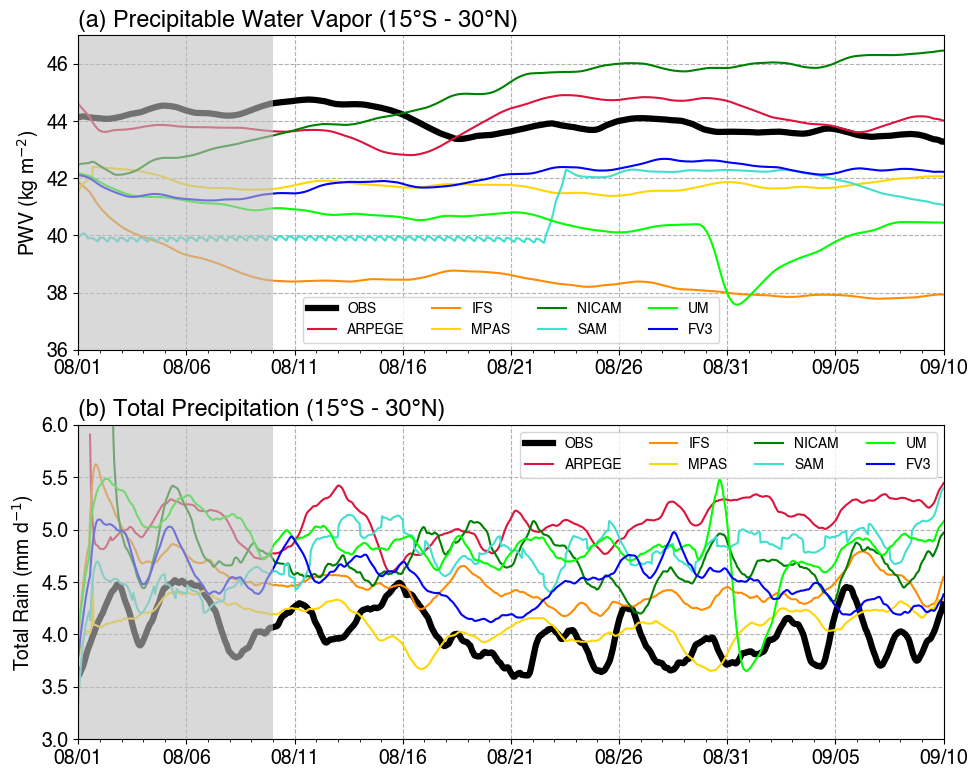

In [14]:
data_arr = [dse_s.intqv, dsr_s.precipitation*24]
time_data = [dse_s.time, dsr_s.time]

titles = [f'(a) Precipitable Water Vapor ({lat_min} - {lat_max})', f'(b) Total Precipitation ({lat_min} - {lat_max})', ]
ylabels = ['PWV (kg m$^{-2}$)', 'Total Rain (mm d$^{-1}$)',]
xlabels = 'Date'
xlims = [dse.time.min().data, dse.time.max().data]
ylims = [(36,47), (3,6),]
legends = name_map
legend_prop = {'ncol':int(len(name_map)/2), 'fontsize':10, 'loc':'best'}
inset_param = {'width':'55%', 'height':'15%', 'loc':'lower left', 'borderpad':0.1}
figname = f'{figdir}globalmean_timeseries_pwv_total_rain_nodiurnal.png'
fig = plot_time_nrow(2, time_data, data_arr, titles, xlabels, ylabels, legends, figname,
                   xlims=xlims, ylims=ylims, block_times=block_times,
                   legend_prop=legend_prop, fontsize=14, figsize=[10,8])

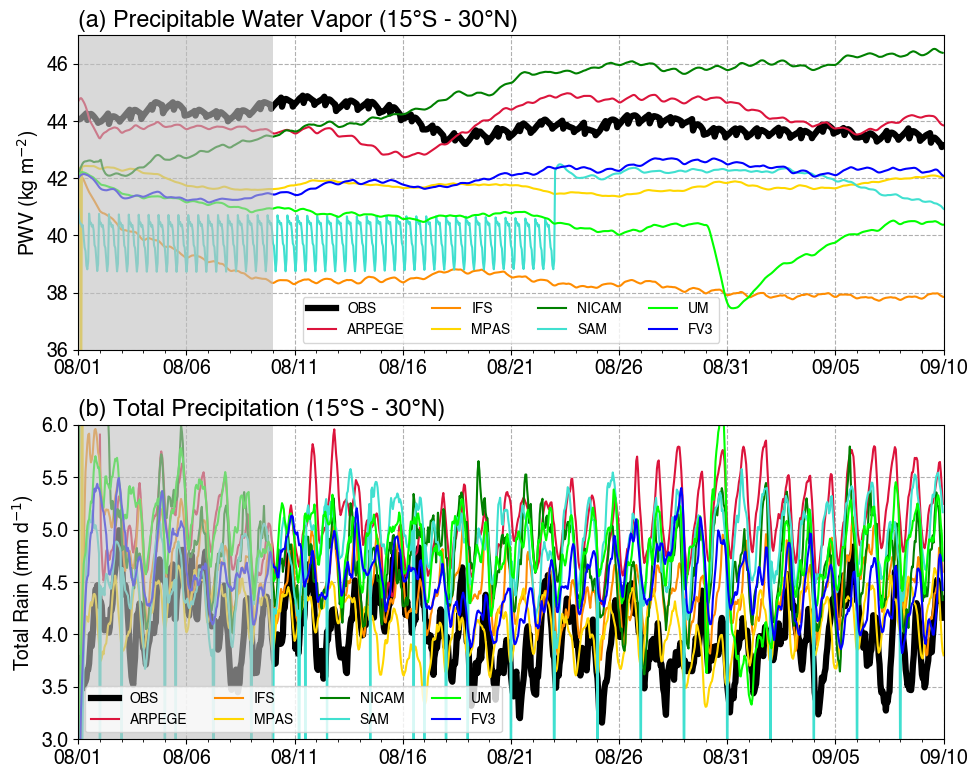

In [15]:
data_arr = [dse.intqv, dsr.precipitation*24]
time_data = [dse.time, dsr.time]

titles = [f'(a) Precipitable Water Vapor ({lat_min} - {lat_max})', f'(b) Total Precipitation ({lat_min} - {lat_max})', ]
ylabels = ['PWV (kg m$^{-2}$)', 'Total Rain (mm d$^{-1}$)',]
xlabels = 'Date'
xlims = [dse.time.min().data, dse.time.max().data]
ylims = [(36,47), (3,6),]
legends = name_map
legend_prop = {'ncol':int(len(name_map)/2), 'fontsize':10, 'loc':'best'}
inset_param = {'width':'55%', 'height':'15%', 'loc':'lower left', 'borderpad':0.1}
figname = f'{figdir}globalmean_timeseries_pwv_total_rain.png'
fig = plot_time_nrow(2, time_data, data_arr, titles, xlabels, ylabels, legends, figname,
                   xlims=xlims, ylims=ylims, block_times=block_times,
                   legend_prop=legend_prop, fontsize=14, figsize=[10,8])

In [13]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/globalmean_timeseries_pwv_total_rain.png'